In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset ,DataLoader
from torchvision import datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt

In [64]:
training_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
)
testing_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=64, shuffle=True)

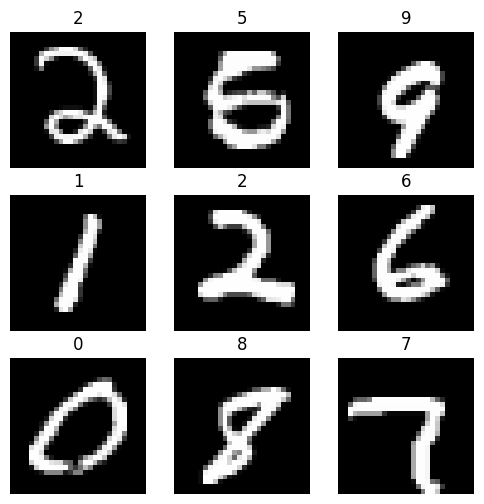

In [65]:
labels_map = {i: str(i) for i in range(10)}
figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis(False)
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()



In [66]:
training_data[0][0].shape

torch.Size([1, 28, 28])

In [155]:
class ConvModelSmol(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #       [N, C, H, W]
        # input [N, 1, 28, 28]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        # output volume of [N, 3, 28, 28]
        self.pool1 = nn.MaxPool2d(2)
        # output volume of [N, 3, 14, 14]

        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        # output volume of [N, 3, 14, 14]
        self.pool2 = nn.MaxPool2d(2)
        # output volume of [N, 3, 7, 7]

        self.flat = nn.Flatten(start_dim=1)
        # output [N, 147]
        self.fc1 = nn.Linear(147, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flat(x)
        # [3136]
        x = self.fc1(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output



In [207]:
class ConvModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #       [N, C, H, W]
        # input [N, 1, 28, 28]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        # output volume of [N, 32, 28, 28]
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        # output volume of [N, 64, 14, 14]

        self.drpout1 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        # output volume of [N, 64, 14, 14]
        self.pool2 = nn.MaxPool2d(2)
        # output volume of [N, 64, 7, 7]
        self.drpout2 = nn.Dropout(0.5)

        self.flat = nn.Flatten(start_dim=1)
        # output [N, 3136]
        self.fc1 = nn.Linear(3136, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.drpout1(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool2(x)
        x = self.drpout2(x)
        x = self.flat(x)
        # [3136]
        x = self.fc1(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=0)
        return output



In [208]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    print(f"Train set size: {size}\n")
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 1000 == 0:
            print(f"Step {batch}/{size} : Loss = {loss}\n")

In [209]:
def test_loop(dataloader, model: torch.nn.Module, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    print(f"Test set size: {size}")
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).float().sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test error: Accuracy: {100*correct}, Avg loss: {test_loss}\n")


In [210]:
device = torch.device("cuda")
my_nn = ConvModel().to(device)

learning_rate = 1e-1
epochs = 14
optimizer = torch.optim.SGD(my_nn.parameters(), lr=learning_rate)
loss_fn = F.nll_loss
# X, y = training_data[0]
# one_hot_output = torch.zeros(10)
# one_hot_output[y] = 1
# print(one_hot_output)
# pred = my_nn(X)
# print(pred)
# print(pred.shape)
# loss = F.nll_loss(pred, torch.tensor(y)).item()
# print(y)
# print(pred.argmax(0))


In [211]:
for t in range(epochs):
    print(f"Epoch {t}\n")
    train_loop(train_dataloader, my_nn, loss_fn, optimizer, device)
    test_loop(test_dataloader, my_nn, loss_fn, device)

Epoch 0

Train set size: 60000

Step 0/60000 : Loss = 4.155860900878906

Test set size: 10000
Test error: Accuracy: 97.09, Avg loss: 2.13633776090707

Epoch 1

Train set size: 60000

Step 0/60000 : Loss = 2.2651724815368652

Test set size: 10000
Test error: Accuracy: 97.81, Avg loss: 2.0779773312009824

Epoch 2

Train set size: 60000

Step 0/60000 : Loss = 2.1541318893432617

Test set size: 10000
Test error: Accuracy: 98.06, Avg loss: 2.0427045169149993

Epoch 3

Train set size: 60000

Step 0/60000 : Loss = 2.074319839477539

Test set size: 10000
Test error: Accuracy: 98.24000000000001, Avg loss: 2.0372208975682593

Epoch 4

Train set size: 60000

Step 0/60000 : Loss = 2.1422481536865234

Test set size: 10000
Test error: Accuracy: 98.56, Avg loss: 2.022426391103465

Epoch 5

Train set size: 60000

Step 0/60000 : Loss = 1.9780434370040894

Test set size: 10000
Test error: Accuracy: 98.57000000000001, Avg loss: 2.0111397166920315

Epoch 6

Train set size: 60000

Step 0/60000 : Loss = 2.1